In [1]:
import numpy as np

def pca_transform(data, n_components):
    # Reshape the data if necessary
    data = data.reshape(data.shape[0], -1)
    
    # Calculate mean
    mean = np.mean(data, axis=0)
    
    # Center the data
    data_centered = data - mean
    
    # Calculate covariance matrix
    cov_matrix = np.cov(data_centered, rowvar=False)
    
    # Compute eigenvectors and eigenvalues
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    
    # Sort eigenvalues and corresponding eigenvectors
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors_sorted = eigenvectors[:, sorted_indices]
    
    # Select top n_components eigenvectors
    pca_matrix = eigenvectors_sorted[:, :n_components]
    
    # Project data onto the principal components
    data_reduced = np.dot(data_centered, pca_matrix )
    
    return data_reduced, pca_matrix

# Load data
mnist_data = np.load('mnist.npz')
X_train = mnist_data['x_train']
y_train = mnist_data['y_train']
x_test = mnist_data['x_test']
y_test = mnist_data['y_test']

# Filter out samples from classes 0 and 1
mask_train = (y_train < 2)
X_train_filtered = X_train[mask_train].reshape(-1, 28*28)
y_train_filtered = y_train[mask_train]

mask_test = (y_test < 2)
x_test_filtered = x_test[mask_test]
y_test_filtered = y_test[mask_test]

# Divide the train set into train and val set
X_val = X_train_filtered[:2000]
y_val = y_train_filtered[:2000]
X_train_filtered = X_train_filtered[2000:]
y_train_filtered = y_train_filtered[2000:]

# Apply PCA and reduce the dimensionality to p = 5
X_reduced_train, pca_matrix  = pca_transform(X_train_filtered, n_components=5)
X_reduced_val = np.dot(X_val.reshape(X_val.shape[0], -1) - np.mean(X_train_filtered, axis=0), pca_matrix)
x_reduced_test = np.dot(x_test_filtered.reshape(x_test_filtered.shape[0], -1) - np.mean(X_train_filtered, axis=0), pca_matrix)

# Label the classes as -1 and 1
y_train_filtered[y_train_filtered == 0] = -1
y_val[y_val == 0] = -1
y_test_filtered[y_test_filtered == 0] = -1
y_train_filtered[y_train_filtered == 1] = 1
y_val[y_val == 1] = 1
y_test_filtered[y_test_filtered == 1] = 1
print(y_train_filtered.shape)
print(y_val.shape)
print(y_test_filtered.shape)
print("Train set shapes after PCA:", X_reduced_train.shape)
print("Validation set shapes after PCA:", X_reduced_val.shape)
print("Test set shapes after PCA:", x_reduced_test.shape)


(10665,)
(2000,)
(2115,)
Train set shapes after PCA: (10665, 5)
Validation set shapes after PCA: (2000, 5)
Test set shapes after PCA: (2115, 5)


C:\Users\dell\AppData\Local\Temp\ipykernel_8452\3996753751.py:59: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  y_train_filtered[y_train_filtered == 0] = -1
C:\Users\dell\AppData\Local\Temp\ipykernel_8452\3996753751.py:60: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  y_val[y_val == 0] = -1
C:\Users\dell\AppData\Local\Temp\ipykernel_8452\3996753751.py:61: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the o

In [2]:
import numpy as np
from sklearn.metrics import mean_squared_error

def decision_stump(X_train, y_train):
    best_feature = None
    best_threshold = None
    best_ssr = float('inf')

    # Iterate over each feature
    for feature in range(X_train.shape[1]):
        # Get unique values and sort them
        unique_values = np.unique(X_train[:, feature])
        
        # Evaluate splits at midpoints
        thresholds = (unique_values[:-1] + unique_values[1:]) / 2
        
        # Evaluate SSR for each split
        for threshold in thresholds:
            # Split data based on threshold
            left_indices = X_train[:, feature] <= threshold
            right_indices = X_train[:, feature] > threshold
            
            left_y = y_train[left_indices]
            right_y = y_train[right_indices]
            
            # Calculate mean of each split
            left_mean = np.mean(left_y)
            right_mean = np.mean(right_y)
            
            # Calculate SSR
            ssr = np.sum((left_y - left_mean) ** 2) + np.sum((right_y - right_mean) ** 2)
            
            # Update best split if SSR is minimized
            if ssr < best_ssr:
                best_ssr = ssr
                best_feature = feature
                best_threshold = threshold
                
    return best_feature, best_threshold

def compute_residuals(y, predictions):
    return y - 0.01 * predictions

def gradient_boosting(X_train, y_train, num_estimators):
    # Initialize the list to store regressors
    regressors = []
    
    # Initialize the residuals
    residues = y_train.astype(np.float64)  # Ensure float64 data type
    
    # Iterate for the number of estimators
    for _ in range(num_estimators):
        # Learn a decision stump
        best_feature, best_threshold = decision_stump(X_train, residues)
        
        # Compute predictions of the current tree
        tree_predictions = np.where(X_train[:, best_feature] <= best_threshold, -0.01, 0.01)
        
        # Update residuals
        residues -= tree_predictions
        
        # Store the learned regressor
        regressors.append((best_feature, best_threshold))
        
    return regressors




MSE on validation set using 1 trees: 30272.020279999993
MSE on validation set using 2 trees: 30274.368760000005
MSE on validation set using 3 trees: 30276.717439999997
MSE on validation set using 4 trees: 30279.066319999998
MSE on validation set using 5 trees: 30281.415400000005


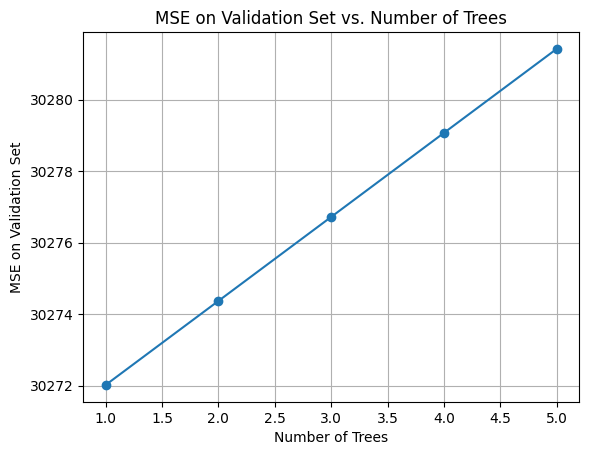

Best number of trees (lowest MSE on validation set): 1
MSE on test set using the selected model: 30132.66199125295


In [4]:
# Train gradient boosting with 300 estimators
gb_regressor = gradient_boosting(X_reduced_train, y_train_filtered, num_estimators=5)

# Initialize a list to store MSE values on the validation set
mse_val_list = []

# Iterate for the number of estimators
for i in range(len(gb_regressor)):
    # Compute predictions of the current ensemble on the validation set
    ensemble_predictions_val = np.zeros_like(y_val, dtype=np.float64)  # Ensure float64 data type
    for j in range(i + 1):
        best_feature, best_threshold = gb_regressor[j]
        
        # Check if the feature index is within the range of the validation set
        if best_feature < X_reduced_val.shape[1]:
            # Use element-wise comparison
            ensemble_predictions_val += np.where(X_reduced_val[:, best_feature] <= best_threshold, -0.01, 0.01)
        else:
            print("Warning: Feature index out of range for validation set.")
            break
    
    # Compute MSE on the validation set
    # Calculate MSE manually
        mse_val = np.mean(np.abs(y_val - ensemble_predictions_val) ** 2)

    
    # Store the MSE value
    mse_val_list.append(mse_val)
    print("MSE on validation set using", i + 1, "trees:", mse_val)

# Find the index of the iteration with the lowest MSE on the validation set
best_iteration = np.argmin(mse_val_list)

# Plot MSE on validation set vs. number of trees
import matplotlib.pyplot as plt



plt.plot(range(1, len(gb_regressor) + 1), mse_val_list, marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('MSE on Validation Set')
plt.title('MSE on Validation Set vs. Number of Trees')
plt.grid(True)
plt.show()

print("Best number of trees (lowest MSE on validation set):", best_iteration + 1)

# Evaluate the selected model on the test set
# Evaluate the selected model on the test set
ensemble_predictions_test = np.zeros_like(y_test_filtered, dtype=np.float64)  # Ensure float64 data type
for i in range(best_iteration + 1):
    best_feature, best_threshold = gb_regressor[i]
    # Use element-wise comparison
    ensemble_predictions_test += np.where(x_reduced_test[:, best_feature] <= best_threshold, -0.01, 0.01)

# Compute MSE on the test set
mse_test = mean_squared_error(y_test_filtered, ensemble_predictions_test)
print("MSE on test set using the selected model:", mse_test)

